In [1]:
#pip install cirq

In [2]:
import sys
sys.path.append('../../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from qick import *
from qick_training import *
from qick.averager_program import QickSweep
from qick.averager_program import merge_sweeps
from RBSupport import generate_2qgateset

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.ticker as mtick

In [3]:
soc = QickSoc()
soccfg = soc

print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.175
	Firmware timestamp: Thu Feb 17 16:46:52 2022

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC ti

# Making pulse sequences

In [4]:
class PulseSequence_debug(AveragerProgram):
    def initialize_phases(self):
        ## Prepare state
        self.phase_ref_q1 = 0
        self.phase_ref_q2 = 0
        self.phase_ref_c = 0
    
    def play_seq(self, seq):
        for g in seq:
            for q in g:
                if q == "Q2":
                    ginfo=self.cfg["gate_set"][g[q]]
                    if g[q]=="Z":
                        self.phase_ref_q2+=180
                    elif g[q]=="Z/2":
                        self.phase_ref_q2+=90
                    elif g[q]=="-Z/2":
                        self.phase_ref_q2+=-90
                    else:
                        self.set_pulse_registers(ch=self.cfg["q2_ch"], freq=self.freq_q2,
                                                 phase=self.deg2reg(self.phase_ref_q2 + ginfo["phase"], gen_ch=self.cfg["q2_ch"]),
                                                 gain=ginfo["gain"], waveform=g[q], phrst=0,mode="oneshot")
                        self.pulse(ch=self.cfg["q2_ch"])
                if q == "Q1": # Qubit 1
                    ginfo=self.cfg["gate_set"][g[q]]
                    """For the Z gates (virtual rotation), we need to advance the phase of all the pulses which follows afterwards"""
                    if g[q]=="Z":
                        self.phase_ref_q1+=180
                    elif g[q]=="Z/2":
                        self.phase_ref_q1+=90
                    elif g[q]=="-Z/2":
                        self.phase_ref_q1+=-90
                    else:
                        self.set_pulse_registers(ch=self.cfg["q1_ch"], freq=self.freq_q1,
                                                 phase=self.deg2reg(self.phase_ref_q1 + ginfo["phase"], gen_ch=self.cfg["q1_ch"]),
                                                 gain=ginfo["gain"], waveform=g[q], phrst=0,mode="oneshot")
                        self.pulse(ch=self.cfg["q1_ch"])
            ################
           #modified sync_all with only DAC clocks, no ADC clocks
            self.synci(self.us2cycles(0.01))
    
    def initialize(self):
        cfg = self.cfg
        self.gate_seq = cfg['gate_seq']
        self.gate_set = cfg['gate_set']
        # set the nyquist zone
        self.declare_gen(ch=cfg["q1_ch"], nqz=1)
        self.declare_gen(ch=cfg["q2_ch"], nqz=1)

        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["q" + str(ch + 1) +"_pulse_freq"], 
                                 gen_ch=cfg["q" + str(ch + 1) +"_ch"])
            
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        self.freq_q1 = self.freq2reg(cfg["q1_pulse_freq"], gen_ch=cfg["q1_ch"], ro_ch=cfg["q1_ro_ch"])
        self.freq_q2 = self.freq2reg(cfg["q2_pulse_freq"], gen_ch=cfg["q2_ch"], ro_ch=cfg["q2_ro_ch"])

        for name, ginfo in self.gate_set.items():
            self.add_pulse(ch=cfg["q1_ch"], name=name,
                           idata=ginfo["idata"],
                           qdata=ginfo["qdata"],
                          )
            self.add_pulse(ch=cfg["q2_ch"], name=name,
                           idata=ginfo["idata"],
                           qdata=ginfo["qdata"],
                          )

        self.default_pulse_registers(ch=cfg["q1_ch"], style="arb")
        self.default_pulse_registers(ch=cfg["q2_ch"], style="arb")

        self.synci(1000)  # give processor some time to configure pulses

    def body(self):
        ## Trigger measurement
        self.trigger(adcs=self.ro_chs,
                     pins=[0],
                     adc_trig_offset=self.cfg["adc_trig_offset"])

        self.initialize_phases()
        self.play_seq(self.gate_seq)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [5]:
# Note: DACs and ADCs should each be on the same tiles! 

In [6]:
config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 2,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(0.01,gen_ch=2),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": 2000,  # [MHz]
          "q2_pulse_freq": 2000,  # [MHz]
          "c_pulse_freq": 2000,  # [MHz]
          "adc_trig_offset": soc.us2cycles(0.52,ro_ch=0),  # [Clock ticks]
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

with open('prep_moments.pkl', 'rb') as f:
    prep_moments = pickle.load(f)

config['gate_seq'] = [{'Q1': 'I', 'Q2': 'X', 'C': 'I'}, {'Q1': 'I', 'Q2': 'I', 'C': 'I'},
                      {'Q1': 'I', 'Q2': 'I', 'C': 'I'}, {'Q1': 'I', 'Q2': 'X', 'C': 'I'}, ]

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X', 'C': 'I'}, {'Q1': 'X', 'Q2': 'X', 'C': 'I'},
                      {'Q1': 'X', 'Q2': 'X', 'C': 'I'} ]


config['gate_seq'] = prep_moments
print(config['gate_seq'])

[{'Q1': 'I', 'Q2': 'I', 'C': 'I'}, {'Q1': 'I', 'Q2': 'X', 'C': 'I'}, {'Q1': 'I', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'I', 'Q2': '-X/2', 'C': 'I'}, {'Q1': 'X', 'Q2': 'I', 'C': 'I'}, {'Q1': 'X', 'Q2': 'X', 'C': 'I'}, {'Q1': 'X', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'X', 'Q2': '-X/2', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'I', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'X', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': '-X/2', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'I', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'X', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': '-X/2', 'Q2': '-X/2', 'C': 'I'}]


In [7]:
prog = PulseSequence_debug(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
iq_lists.append(iq_list)

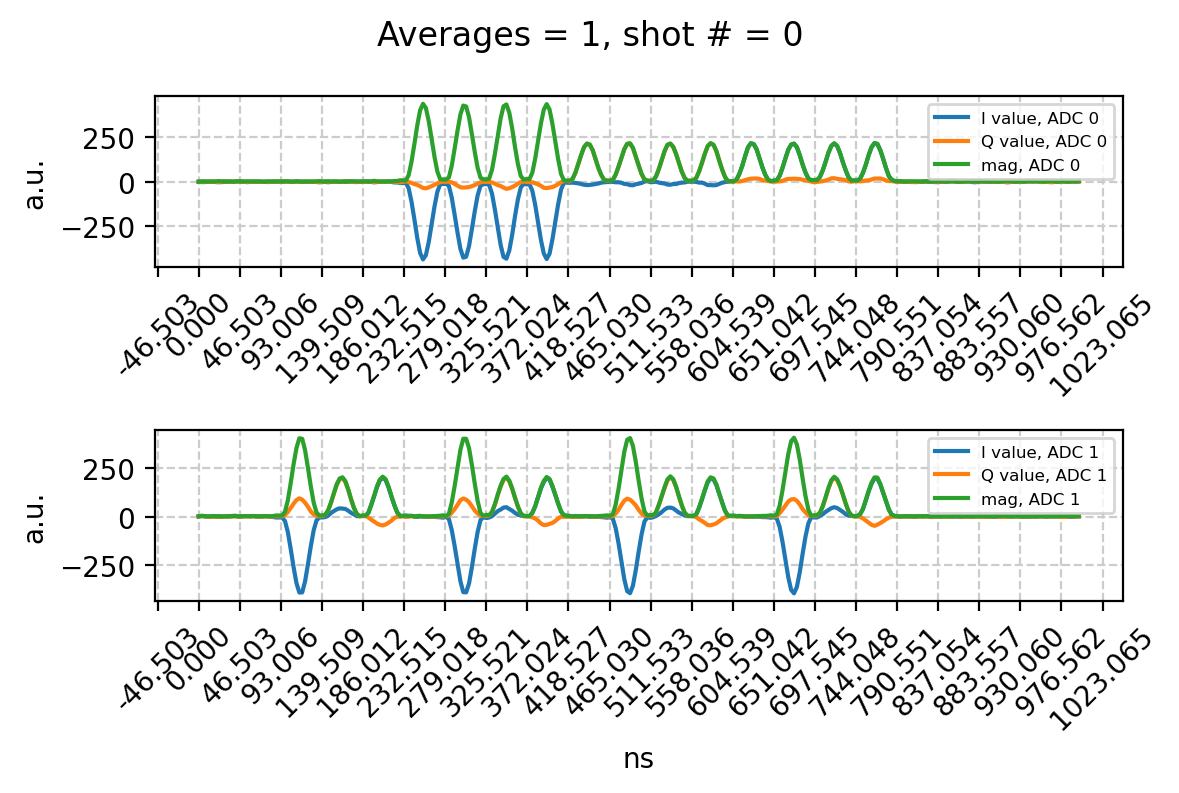

In [8]:
for n in range(0, len(iq_lists)):
    fig, axs = plt.subplots(len(iq_lists[n]),dpi=200)
    fig.suptitle("Averages = " + str(config["soft_avgs"]) + ", shot # = " + str(n))
    for ii, iq in enumerate(iq_lists[n]):
        axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                            ),iq[0], label="I value, ADC %d" % (config['ro_chs'][ii]))
        axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                            ),iq[1], label="Q value, ADC %d" % (config['ro_chs'][ii]))
        axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                            ),np.abs(iq[0] + 1j * iq[1]), label="mag, ADC %d" % (config['ro_chs'][ii]))
        axs[ii].legend(loc=1, prop={'size': 6})
        axs[ii].set_ylabel("a.u.")
        axs[ii].xaxis.set_major_locator(MultipleLocator(1000*5*soc.cycles2us(4, gen_ch = 0)))
        axs[ii].grid(which='major', color='#CCCCCC', linestyle='--')
        axs[ii].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
        axs[ii].tick_params(axis='x', rotation=45)

    plt.xlabel('ns')
    plt.tight_layout()

In [9]:
print(config['gate_seq'])

[{'Q1': 'I', 'Q2': 'I', 'C': 'I'}, {'Q1': 'I', 'Q2': 'X', 'C': 'I'}, {'Q1': 'I', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'I', 'Q2': '-X/2', 'C': 'I'}, {'Q1': 'X', 'Q2': 'I', 'C': 'I'}, {'Q1': 'X', 'Q2': 'X', 'C': 'I'}, {'Q1': 'X', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'X', 'Q2': '-X/2', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'I', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'X', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': '-X/2', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'I', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'X', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': '-X/2', 'Q2': '-X/2', 'C': 'I'}]
